In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
 
from alibi_detect.od import IForest
from alibi_detect.datasets import fetch_kdd
from alibi_detect.utils.data import create_outlier_batch
from alibi_detect.utils.fetching import fetch_detector
from alibi_detect.utils.saving import save_detector, load_detector
from alibi_detect.utils.visualize import plot_instance_score, plot_roc

In [2]:
# load data
kddcup = fetch_kdd(percent10=True)  # only load 10% of the dataset

In [10]:
print(kddcup.data[:5])
print(kddcup.target[:5])
print(kddcup.feature_names)

[[8 0.0 0.0 0.0 0.0 1.0 0.0 0.0 9 9 1.0 0.0 0.11 0.0 0.0 0.0 0.0 0.0]
 [8 0.0 0.0 0.0 0.0 1.0 0.0 0.0 19 19 1.0 0.0 0.05 0.0 0.0 0.0 0.0 0.0]
 [8 0.0 0.0 0.0 0.0 1.0 0.0 0.0 29 29 1.0 0.0 0.03 0.0 0.0 0.0 0.0 0.0]
 [6 0.0 0.0 0.0 0.0 1.0 0.0 0.0 39 39 1.0 0.0 0.03 0.0 0.0 0.0 0.0 0.0]
 [6 0.0 0.0 0.0 0.0 1.0 0.0 0.0 49 49 1.0 0.0 0.02 0.0 0.0 0.0 0.0 0.0]]
[0 0 0 0 0]
['srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate']


In [5]:
print("features shape:", kddcup.data.shape)
print("labels shape:", kddcup.target.shape)

features shape: (494021, 18)
labels shape: (494021,)


In [11]:
np.random.seed(0)
normal_batch = create_outlier_batch(kddcup.data, kddcup.target, n_samples=400000, perc_outlier=0)
X_train, y_train = normal_batch.data.astype('float'), normal_batch.target

In [13]:
X_train.shape

(400000, 18)

In [14]:
# apply normalization
mean, stdev = X_train.mean(axis=0), X_train.std(axis=0)
X_train = (X_train - mean) / stdev

In [17]:
X_train

array([[ 0.87691783, -0.05591707, -0.06682876, ..., -0.06649794,
        -0.25559753, -0.2535942 ],
       [ 0.09416073, -0.05591707, -0.06682876, ..., -0.06649794,
        -0.25559753, -0.2535942 ],
       [ 0.41647248,  1.74067299,  1.84535077, ..., -0.06649794,
        -0.25559753, -0.2535942 ],
       ...,
       [ 0.60065062, -0.05591707, -0.06682876, ..., -0.06649794,
        -0.21100034, -0.20768021],
       [-0.45837369, -0.05591707, -0.06682876, ..., -0.06649794,
         1.57288721,  1.99619116],
       [ 0.41647248, -0.05591707, -0.06682876, ..., -0.06649794,
        -0.25559753, -0.2535942 ]])

In [18]:
# initialize outlier detector
od = IForest(threshold=None,n_estimators=100)

No threshold level set. Need to infer threshold using `infer_threshold`.


In [19]:
# train
od.fit(X_train)

In [25]:
# create batch of outlier
np.random.seed(0)
perc_outlier = 5
threshold_batch = create_outlier_batch(kddcup.data, kddcup.target, n_samples=1000, perc_outlier=perc_outlier)
X_threshold, y_threshold = threshold_batch.data.astype('float'), threshold_batch.target
X_threshold = (X_threshold - mean) / stdev
print('{}% outliers'.format(100 * y_threshold.mean()))

5.0% outliers


In [24]:
X_threshold.mean() * 100

10.608578523271293

In [22]:
# add threshold to detector
od.infer_threshold(X_threshold, threshold_perc=100-perc_outlier)
print('New threshold: {}'.format(od.threshold))

New threshold: 0.0797010793476482


In [23]:
# new batch for prediction
np.random.seed(1)
outlier_batch = create_outlier_batch(kddcup.data, kddcup.target, n_samples=1000, perc_outlier=10)
X_outlier, y_outlier = outlier_batch.data.astype('float'), outlier_batch.target
X_outlier = (X_outlier - mean) / stdev
print(X_outlier.shape, y_outlier.shape)
print('{}% outliers'.format(100 * y_outlier.mean()))

(1000, 18) (1000,)
10.0% outliers


In [24]:
# predicting
od_preds = od.predict(X_outlier, return_instance_score=True)

F1 score: 0.3279,
 Accuracy Score: 0.8770


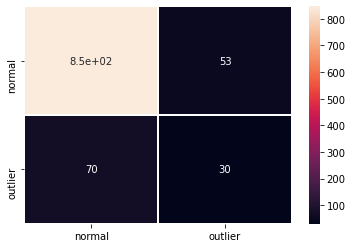

In [27]:
labels = outlier_batch.target_names
y_pred = od_preds['data']['is_outlier']
f1 = f1_score(y_outlier, y_pred)
acc = accuracy_score(y_outlier, y_pred)
print('F1 score: {:.4f},\n Accuracy Score: {:.4f}'.format(f1, acc))
cm = confusion_matrix(y_outlier, y_pred)
df_cm = pd.DataFrame(cm, index=labels, columns=labels)
sns.heatmap(df_cm, annot=True, cbar=True, linewidths=.5)
plt.show()

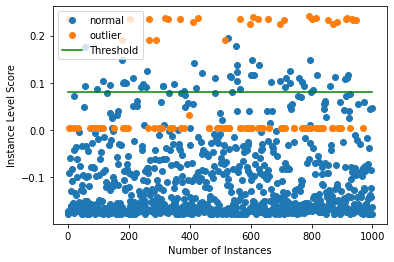

In [28]:
plot_instance_score(od_preds, y_outlier, labels, od.threshold)